In [34]:


#The main file for case 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Path to main file
file_Moa = "/Users/moasjoberg/Documents/Turbulence_cource/Turbulence_course/FALL2_1.TXT"


# Read as space-separated values
df = pd.read_csv(file_Moa, delim_whitespace=True, header=None)




#retrieve variables
R = df.iloc[:, 8].to_numpy()  # Nettradiationn in column 23 W/m2
G= df.iloc[:, 9] # GROUND HEAT FLUX AT EACH HEGHT in column 18-22 (22 INCLUDED) W/m2
p=df.iloc[:, 7].to_numpy()  # air pressure #hpa
theta= df.iloc[:, 5].to_numpy()  # Potential temperature at height
r= df.iloc[:,6].to_numpy() #relative humidity at height 2
u= df.iloc[:,4].to_numpy() #windspeed at height 10.1m 

#Constants
rho =  1.225 # kg/m³ - density of air at sea level (is it always the same?)
c_p= 1005 # J/(kg·K) specific heat of air at sea level
gamma= (c_p * p /10) / (0.622 * 2.45*10**6) # kPa /K - psycometric constant γ=cp⋅P/ (ε⋅λ)  (lambda is latent heat of vaporization, epsilon molecular weight of water vapor to dry air)

r_l = 100 #s m^-1 stomatal resistance of single leaf (well watered condition)
karman= 0.41



#12cm
h = 0.12 # 12 cm
z0_m12 = h/10
z0_h12= z0_m12 /20 
#33cm
z_0m33=0.0329 
z_0h33=0.00177
#60cm
h = 0.6 # 12 cm
z_0m60 = h/10
z_0h60 = z_0m60 /20 

heights = [0.12, 0.329, 0.6]
z_0m_values = [z0_m12, z_0m33, z_0m60]
z_0h_values = [z0_h12, z_0h33, z_0h60]


#Changes in different height cases!
h_max= 1.5 #m (approx for barley)
LAI_max= 4 #barley
n= 1 # barley 1-2

print(gamma)


[0.06670763 0.06670103 0.06668784 0.06667465 0.06666806 0.06666146
 0.06665487 0.06664168 0.06662849 0.06662189 0.0666087  0.06660211
 0.06658892 0.06658232 0.06657573 0.06656254 0.06655594 0.06654935
 0.06653616 0.06652956 0.06651637 0.06650318 0.06649659 0.06648999
 0.0664834  0.0664834  0.0664768  0.06647021 0.06646361 0.06645042
 0.06644383 0.06643064 0.06642404 0.06641085 0.06639766 0.06638447
 0.06637128 0.06636469 0.06635809 0.0663515  0.06633831 0.06632512
 0.06631193 0.06629874 0.06629215 0.06628555 0.06627236 0.06625917
 0.06624598 0.06623279 0.0662196  0.0662196  0.06621301 0.06620641
 0.06619322 0.06618663 0.06617344 0.06615365 0.06614046 0.06613387
 0.06612068 0.06611408 0.06610089 0.0660877  0.06606792 0.06605473
 0.06604154 0.06602835 0.06601516 0.06600197 0.06598878 0.06597559
 0.0659624  0.06594921 0.06593404 0.06592085 0.06591294 0.06589909
 0.0658826  0.06586875 0.06585952 0.06585556 0.06586084 0.06586479
 0.06586611 0.06585952 0.06585029 0.06584105 0.06582984 0.0658

In [35]:
# help functions

def pottemp_to_temp(theta):   # in celsius
    T=theta * (p/1000)**0.286
    return T


# we calculate difference e_s-e_a
def vapour_pressure_deficit(T): 
    e_s= 0.6108 * np.exp(17.27 * T / (237.3 +T)) #Tetens equation
    e_a= r / 100 * e_s    
    return e_s-e_a

# slope of the saturation curve
def gradient_e_s (e_s,T): 
    delta= e_s * 4097.871 / (237.3 + T)**2
    return delta

def resistance_aero(z_m, z_h, d, z_0m, z_0h, u):
    with np.errstate(divide="ignore", invalid="ignore"):
        r_a = (np.log((z_m - d) / z_0m) * np.log((z_h - d) / z_0h)) / (karman**2 * u)
    
    #Replace invalid/very large values with NaN
    r_a = np.where(np.isfinite(r_a), r_a, np.nan)
    r_a = np.where((r_a > 1e6) | (r_a < 0), np.nan, r_a)  # optional thresholding
    
    return r_a



    

In [36]:
z_m= 10.1 #m heigth of wind meausurement 
z_h=1.95 #m height of humidity measurement
T = pottemp_to_temp(theta) # Temperature K

e_s= 0.6108  * np.exp(17.27 * T/ (237.3 +T)) #Tetens equation. 
e_sa= vapour_pressure_deficit(T) 
delta= gradient_e_s(e_s, T)


 


In [37]:

ET = np.zeros((len(heights), len(R)), dtype=float)

for idx, h in enumerate(heights):
    # Leaf area and resistance
    d = 0.65*h 
    z_0m= z_0m_values[idx]
    z_0h= z_0h_values[idx]
    LAI = LAI_max * (h / h_max)**n
    LAI_active = 0.5 * LAI
    r_s = r_l / LAI_active
    r_a = resistance_aero(z_m,z_h, d, z_0m,z_0h, u)


    # Compute ET at each time
    ET[idx, :] = (delta * (R - G) + rho * c_p * e_sa / r_a) / (delta + gamma * (1 + r_s / r_a)) 

np.save("ET_main_data1.npy", ET)



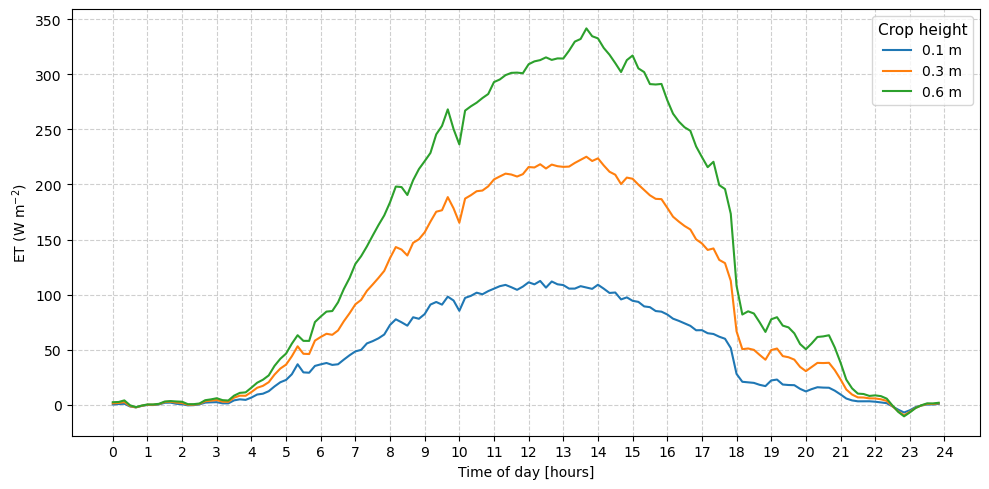

In [38]:


# Continuous time axis in hours (0–24 in 10 min steps)
time_hours = np.arange(0, 24, 10/60)   # 144 points


plt.figure(figsize=(10,5))


for idx, h in enumerate(heights):
    plt.plot(
        time_hours, ET[idx, :],
        label=f"{h:.1f} m",
        linewidth=1.5,
    )

plt.xlabel("Time of day [hours]")
plt.ylabel("ET (W m$^{-2}$)")
#plt.title("Evapotranspiration (ET) over 24h")
plt.grid(True)

# Show ticks every hour
plt.xticks(range(0, 25, 1))
plt.legend(title="Crop height", fontsize=10, title_fontsize=11, loc="upper right")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

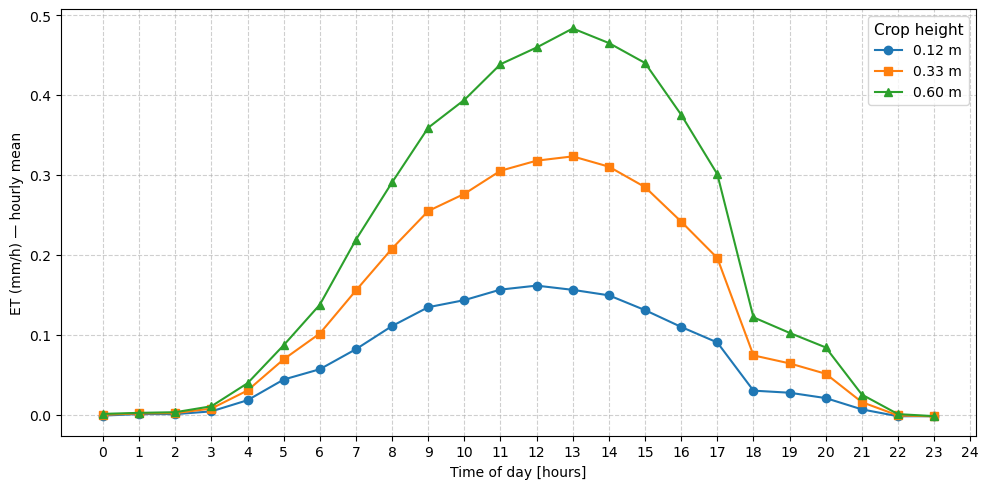

In [39]:
L= 2.45 * 10**6
ET_mm = (ET * 3600) / L

steps_per_hour = 6
total_hours = 24
expected_len = total_hours * steps_per_hour

# Safety: trim to whole hours if needed
ET_mm_trim = ET_mm[:, :expected_len]

# Hourly means: reshape [heights, 24, 6] → mean over the last axis
ET_mm_hourly = ET_mm_trim.reshape(len(heights), total_hours, steps_per_hour).mean(axis=2)

# Hour ticks 0..23
hours = np.arange(total_hours)

# Markers: circle, square, triangle (then cycle if more than 3 heights)
markers = ['o', 's', '^']

plt.figure(figsize=(10,5))

for idx, h in enumerate(heights):
    marker = markers[idx % len(markers)]
    plt.plot(
        hours,
        ET_mm_hourly[idx, :],
        linestyle='-',
        marker=marker,
        label=f"{h:.2f} m"
    )

plt.xticks(range(0, 25, 1))
plt.xlabel("Time of day [hours]")
plt.ylabel("ET (mm/h) — hourly mean")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Crop height", fontsize=10, title_fontsize=11, loc="upper right")
plt.tight_layout()
plt.show()

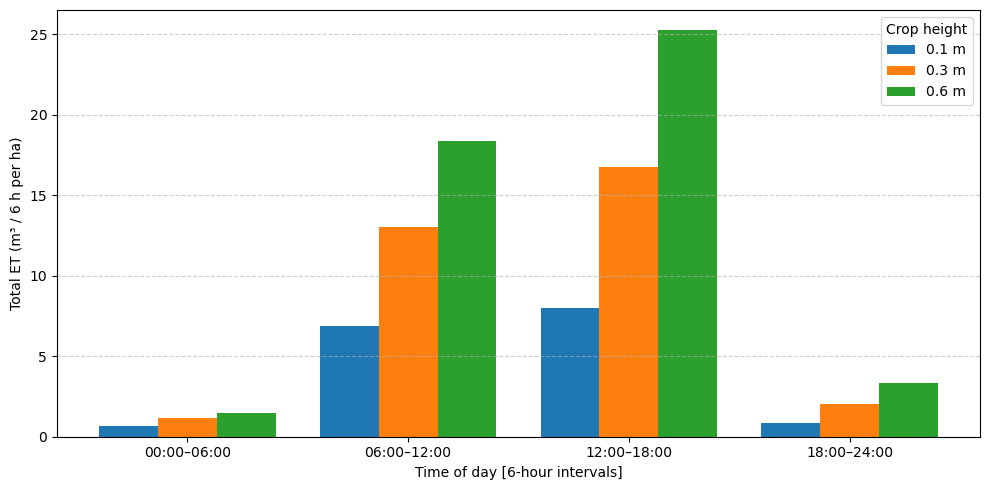

In [40]:
#Cost mm/h -> m^3/period
#A= 10000 # m^2 - 1 hectar
#E_m=ET_mm * 10 #A *0.001 #m^3/h

# 6-hour bin edges (0–6, 6–12, 12–18, 18–24)
bin_edges  = np.arange(0, 25, 6)
bin_labels = [f"{bin_edges[i]:02.0f}:00–{bin_edges[i+1]:02.0f}:00" for i in range(len(bin_edges)-1)]

steps_per_bin = 36           # 6 h * 60 / 10
dt_hours = 10/60             # 1/6 h per step

# ET_mm shape: [heights, 144] in mm/h
ET_m3h = ET_mm * 10          # rate: m³/h per ha (1 mm/h = 10 m³/h/ha)

# Convert to volume per step, then sum
ET_m3_per_step = ET_m3h * dt_hours   # m³ per step
ET_m3_bins = ET_m3_per_step.reshape(len(heights), 4, steps_per_bin).sum(axis=2)  # m³/6 h

# Plot
x = np.arange(len(bin_labels))
width = 0.8 / len(heights)   # auto width so groups fit
offsets = (np.arange(len(heights)) - (len(heights)-1)/2) * width

plt.figure(figsize=(10,5))
for idx, h in enumerate(heights):
    plt.bar(x + offsets[idx], ET_m3_bins[idx], width=width, label=f"{h:.1f} m")
plt.xticks(x, bin_labels)
plt.xlabel("Time of day [6-hour intervals]")
plt.ylabel("Total ET (m³ / 6 h per ha)")
plt.legend(title="Crop height", fontsize=10)
plt.grid(True, linestyle="--", axis="y", alpha=0.6)
plt.tight_layout()
plt.show()


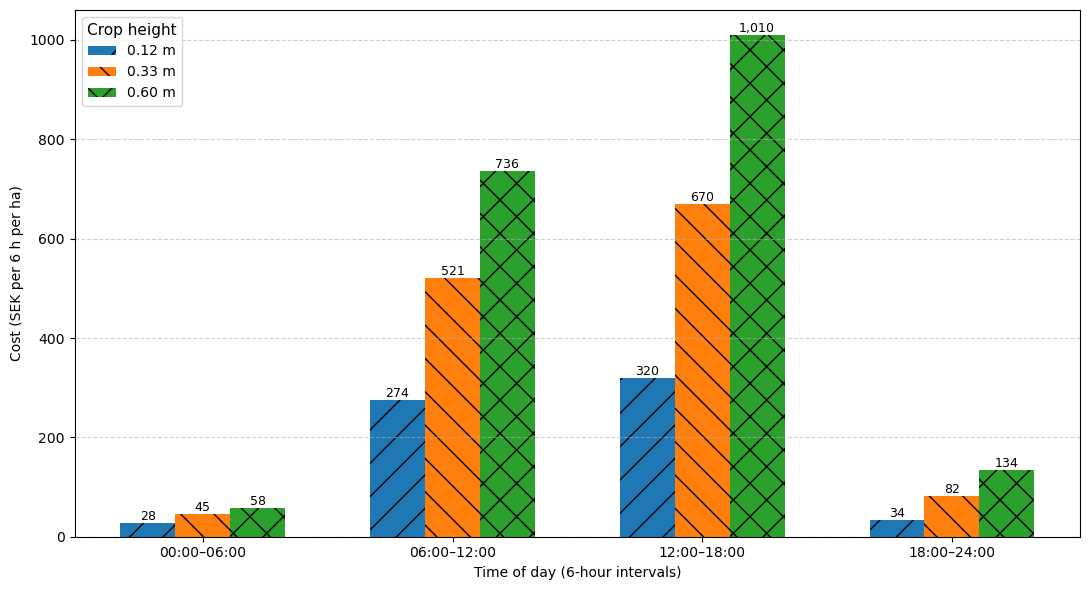

In [43]:

price_per_m3 = 40          # SEK per m³
bar_width = 0.22
hatches = ['/', '\\', 'x', 'o', '.', '*']
label_fmt = "{:,.0f}"       # rounded SEK

# ------------------------
# Binning (6-hour blocks)
# ------------------------
bin_edges  = np.arange(0, 25, 6)  # [0, 6, 12, 18, 24]
bin_labels = [f"{bin_edges[i]:02.0f}:00–{bin_edges[i+1]:02.0f}:00" for i in range(len(bin_edges)-1)]

steps_per_bin = 36                 # 6 h * 60 / 10
dt_hours = 10/60                   # 1/6 h per step

# ET_mm shape assumed: [n_heights, 144], units mm/h
# Convert mm/h → m³/h per ha (1 mm/h over 1 ha = 10 m³/h)
ET_m3h = ET_mm * 10.0

# Convert to volume per step, then sum within each 6 h bin
ET_m3_per_step = ET_m3h * dt_hours                               # [n_heights, 144] m³/step
ET_m3_bins = ET_m3_per_step.reshape(len(heights), 4, steps_per_bin).sum(axis=2)  # [n_heights, 4] m³/6h

# Cost per 6 h per ha
values = ET_m3_bins * price_per_m3    # SEK per 6 h per ha

# ------------------------
# Plot
# ------------------------
x = np.arange(len(bin_labels))  # [0,1,2,3]
group_offset = (np.arange(len(heights)) - (len(heights)-1)/2.0) * bar_width

plt.figure(figsize=(11, 6))
for idx, h in enumerate(heights):
    positions = x + group_offset[idx]
    bars = plt.bar(
        positions,
        values[idx, :],
        width=bar_width,
        hatch=hatches[idx % len(hatches)],
        label=f"{h:.2f} m",
        linewidth=1.0
    )
    # Value labels
    for r in bars:
        height = r.get_height()
        if np.isfinite(height) and height > 0:
            plt.text(
                r.get_x() + r.get_width()/2.0,
                height,
                label_fmt.format(height),
                ha='center', va='bottom',
                fontsize=9
            )

plt.xticks(x, bin_labels)
plt.xlabel("Time of day (6-hour intervals)")
plt.ylabel("Cost (SEK per 6 h per ha)")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Crop height", fontsize=10, title_fontsize=11, loc="upper left", frameon=True)
plt.tight_layout()
plt.show()


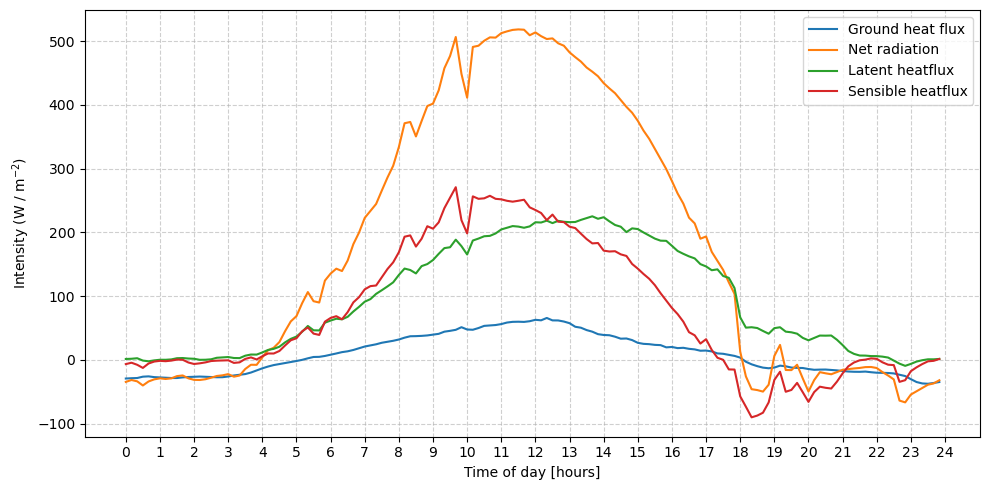

In [42]:

#For crop height 33 cm

# Continuous time axis in hours (0–24 in 10 min steps)
time_hours = np.arange(0, 24, 10/60)   # 144 points


plt.figure(figsize=(10,5))


plt.plot( time_hours, G , label= "Ground heat flux" , linewidth=1.5) #Ground heatflux
plt.plot( time_hours, R , label= "Net radiation" , linewidth=1.5) #Nett radiation
plt.plot( time_hours, ET[1,:]  , label= "Latent heatflux" , linewidth=1.5)  #Latent heat flux
plt.plot( time_hours, (R-G)-ET[1,:], label= "Sensible heatflux" , linewidth=1.5)  #Sensible heat flux

plt.xlabel("Time of day [hours]")
plt.ylabel("Intensity (W / m$^{-2}$)")

plt.grid(True)

# Show ticks every hour
plt.xticks(range(0, 25, 1))
plt.legend( fontsize=10, title_fontsize=11, loc="upper right")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()